# Leaky integrate and fire

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import brian2 as b

## Neurons

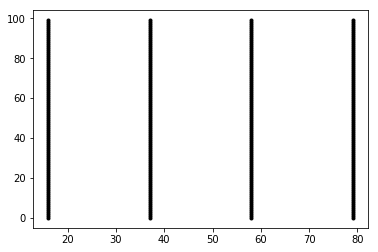

In [5]:
b.start_scope()

N = 100
tau_membrane = 10 * b.ms
equations = '''
dv/dt = (1 - v) / tau_membrane : 1 (unless refractory)
'''

neuron_group = b.NeuronGroup( N, equations,
                              threshold = 'v > 0.8',
                              reset = 'v = 0',
                              refractory = 5 * b.ms,
                              method = 'euler' )

state_monitor = b.StateMonitor( neuron_group, 'v', record = 0 )
spike_monitor = b.SpikeMonitor( neuron_group )

b.run( 100 * b.ms )

plt.plot( spike_monitor.t / b.ms, spike_monitor.i, 'k.' )

## Synapses

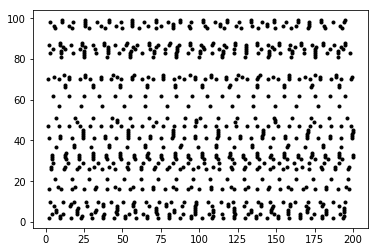

In [18]:
b.start_scope()

N = 100
tau_membrane = 10 * b.ms
equations = '''
dv/dt = (I - v) / tau_membrane : 1 (unless refractory)
I : 1
'''

neuron_group = b.NeuronGroup( N, equations,
                              threshold = 'v > 0.8',
                              reset = 'v = 0',
                              refractory = 5 * b.ms,
                              method = 'euler' )
neuron_group.I = np.random.exponential( size = (N,) )

synapses = b.Synapses( neuron_group, neuron_group,
                       on_pre = 'v_post += 0.3' )

for i in range( N - 1 ):
    synapses.connect( i = i, j = i + 1 )

state_monitor = b.StateMonitor( neuron_group, 'v', record = True )
spike_monitor = b.SpikeMonitor( neuron_group )

b.run( 200 * b.ms )

plt.plot( spike_monitor.t / b.ms, spike_monitor.i, 'k.' )

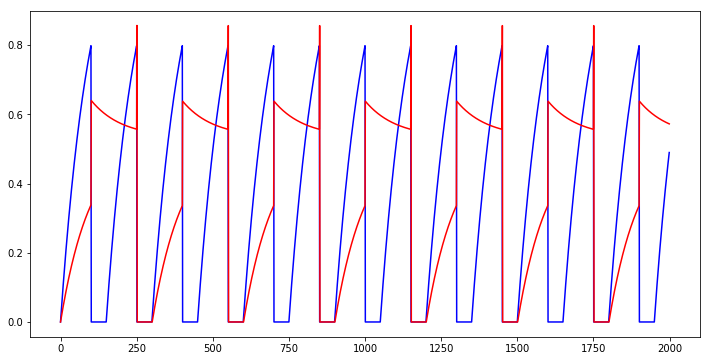

In [23]:
plt.figure( figsize = (12, 6) )
plt.plot( state_monitor.v[81, :], 'b-' )
plt.plot( state_monitor.v[82, :], 'r-' )

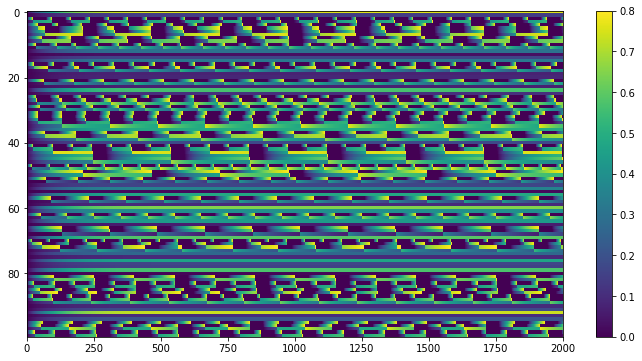

In [20]:
plt.figure( figsize = (12, 6) )
plt.imshow( state_monitor.v, aspect = 'auto' )
plt.clim( 0., 0.8 )
plt.colorbar()

## STDP

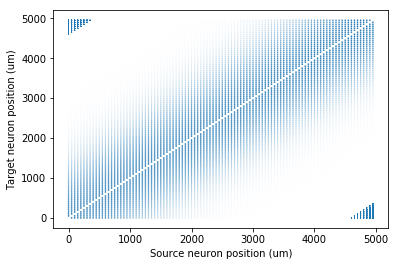

In [32]:
b.start_scope()

N = 100

tau_membrane = 10 * b.ms
tau_pre_synapse = 20 * b.ms
tau_post_synapse = 20 * b.ms

w_max = 0.02
Apre = -0.002
Apost = -Apre * ( tau_pre_synapse / tau_post_synapse ) * 0.95 # 1.05

neuron_spacing = 50 * b.umeter
total_width = (N / 8.) * neuron_spacing

neuron_equations = '''
dv/dt = (I - v) / tau_membrane : 1 (unless refractory)
I : 1
x : meter
'''

neuron_group = b.NeuronGroup( N, neuron_equations,
                              threshold = 'v > 0.8',
                              reset = 'v = 0',
                              refractory = 5 * b.ms,
                              method = 'euler' )
neuron_group.I = np.random.exponential( size = (N,) ) * 1.
neuron_group.x = 'i * neuron_spacing'

synapse_equations = '''
w : 1
dapre/dt = -apre / tau_pre_synapse : 1 (event-driven)
dapost/dt = -apost / tau_post_synapse : 1 (event-driven)
'''
synapse_on_pre = '''
v_post += w
apre += Apre
w = clip( w + apost, 0, w_max)
'''
synapse_on_post = '''
apost += Apost
w = clip( w + apre, 0, w_max)
'''

synapses = b.Synapses( neuron_group, neuron_group, synapse_equations,
                       on_pre = synapse_on_pre,
                       on_post = synapse_on_post )

synapses.connect( condition = 'i != j' )
synapses.w = 'w_max * exp( -( x_pre - x_post ) ** 2 / ( 2 * total_width ** 2 ) )'

plt.scatter( synapses.x_pre/b.um, synapses.x_post/b.um, synapses.w*20)
plt.xlabel('Source neuron position (um)')
plt.ylabel('Target neuron position (um)');

state_monitor = b.StateMonitor( neuron_group, 'v', record = True )
spike_monitor = b.SpikeMonitor( neuron_group, variables = 'v' )

# synapse_monitor = b.StateMonitor( synapses, ['w', 'i', 'j'], record = True )

b.run( 2000 * b.ms )

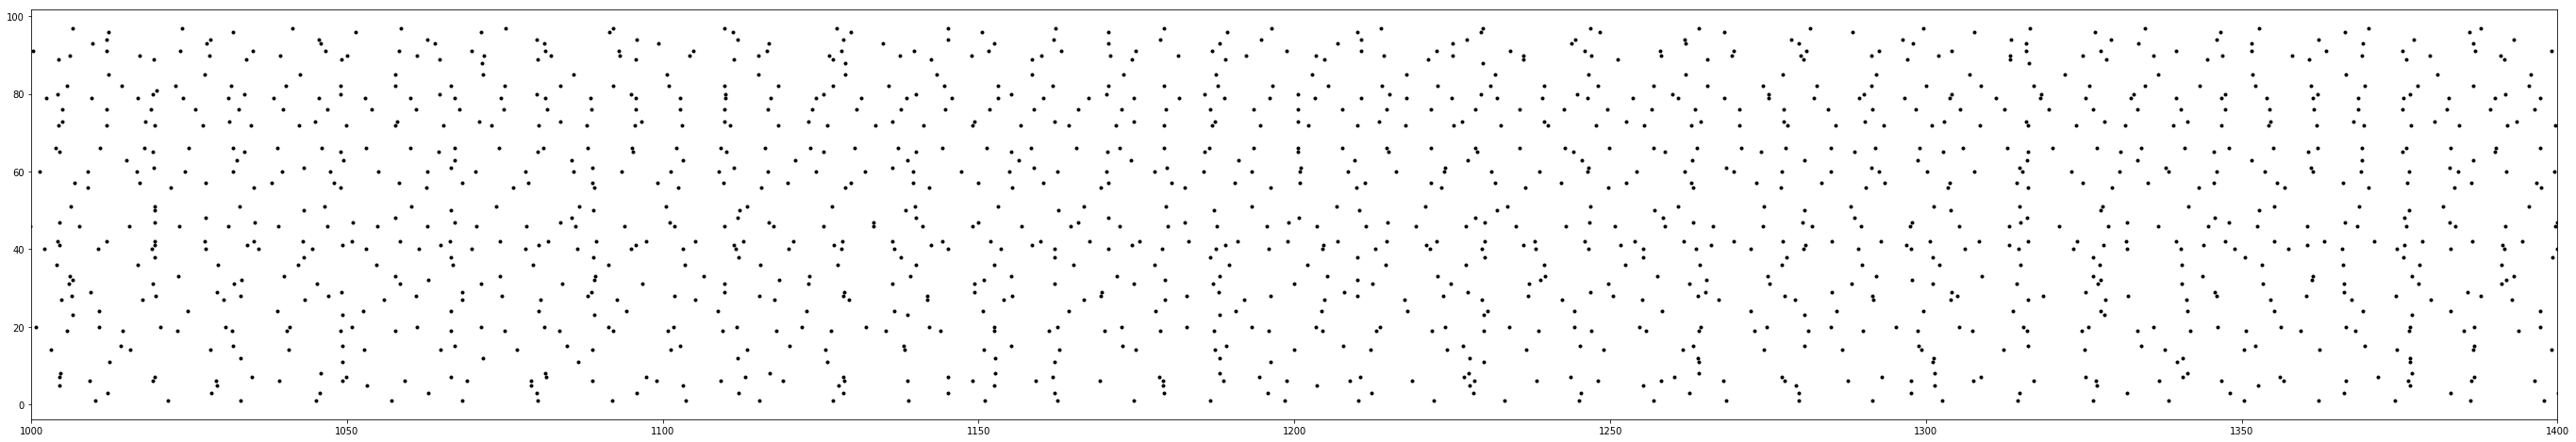

In [35]:
plt.figure( figsize = (48, 8) )
plt.plot( spike_monitor.t / b.ms, spike_monitor.i, 'k.' )
plt.xlim( 1000, 1400 )
plt.show()

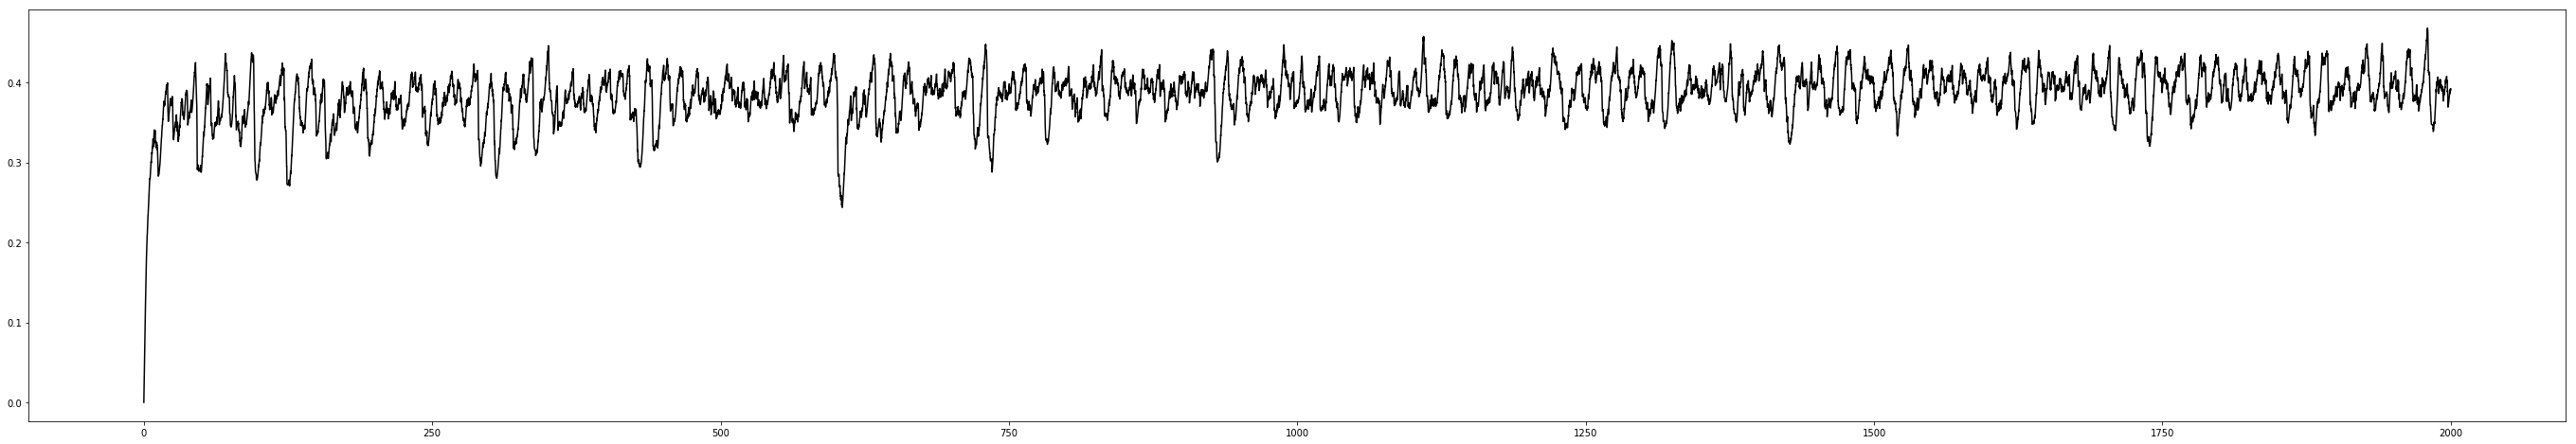

In [36]:
plt.figure( figsize = (48, 8) )
plt.plot( state_monitor.t / b.ms, np.mean( state_monitor.v, axis = 0 ), 'k-' )

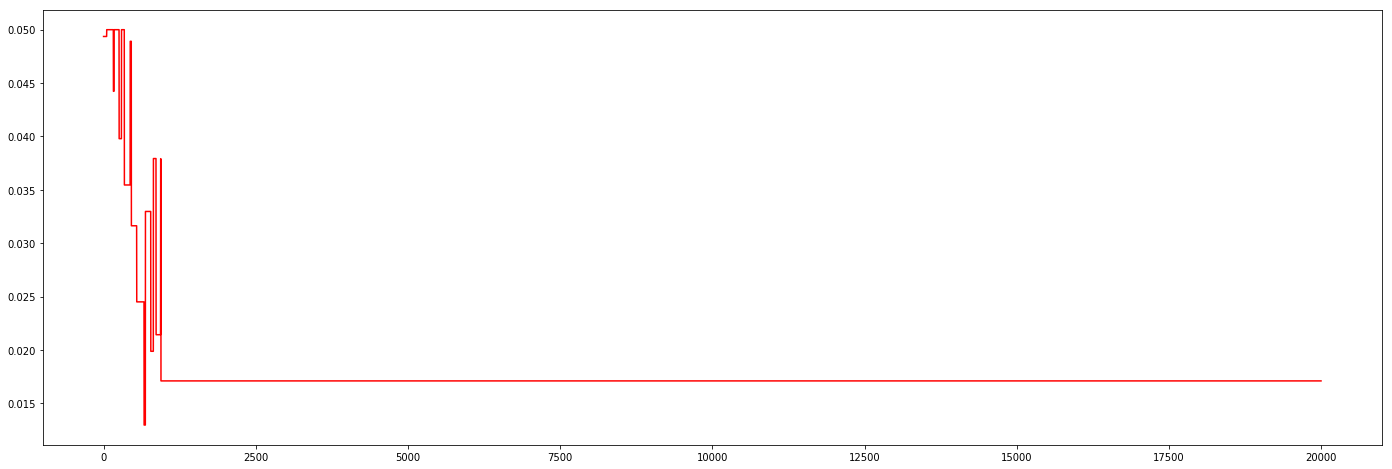

In [11]:
synapse_i =  synapse_monitor.i[:, 0]
synapse_j = synapse_monitor.j[:, 0]

plt.figure( figsize = (24, 8) )
plt.plot( synapse_monitor.w[1001, :], 'r-' )

In [6]:
import gc
gc.collect()

2196

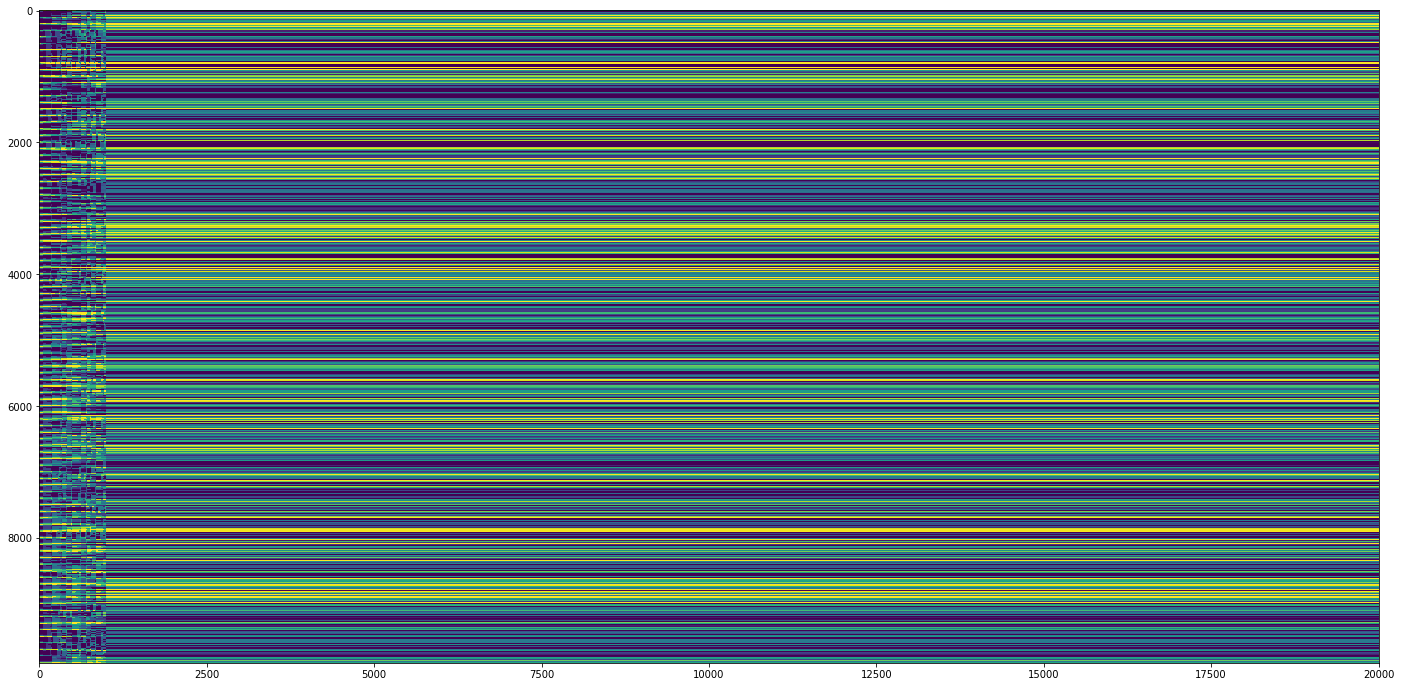

In [7]:
plt.figure( figsize = (24, 12) )
plt.imshow( synapse_monitor.w, aspect = 'auto' )
plt.clim( 0, 0.05 )

In [8]:
import gc
gc.collect()

2260

## Astrocytes

In [44]:
b.start_scope()

Nx = 10
Ny = 10

N = Nx * Ny
Na = N // 2

print( 'Setting up input...', end = '' )
N_input = 1000
inputs = b.PoissonGroup( N_input, 40 * b.Hz )
print( 'Done' )

print( 'Setting up neurons...', end = '' )

tau_membrane = 10 * b.ms # 10
neuron_spacing = 50 * b.um
total_width = neuron_spacing * Nx
total_height = neuron_spacing * Ny
equations = '''
dv/dt = (I - v) / tau_membrane : 1 (unless refractory)
I : 1
x : meter
y : meter
'''
neurons = b.NeuronGroup( N, equations,
                         threshold = 'v > 0.8',
                         reset = 'v = 0',
                         refractory = 5 * b.ms,
                         method = 'rk4' )
# neurons.I = np.random.exponential( size = (N,) ) * 2.
neurons.I = 0
for i_x in range( Nx ):
    for i_y in range( Ny ):
        i_cur = i_x + (i_y * Ny)
        neurons.x[i_cur] = neuron_spacing * i_x
        neurons.y[i_cur] = neuron_spacing * i_y

print( 'Done' )

print( 'Setting up input connectivity...', end = '' )
w_input = 0.05
p_input = 0.05
input_synapses = b.Synapses( inputs, neurons, on_pre = 'v_post += w_input' )
input_synapses.connect( p = p_input )
print( 'Done' )

print( 'Setting up astrocytes...', end = '' )

tau_mean_field = 10 * b.ms
tau_astrocyte = 100 * b.ms
astrocyte_equations = '''
abar : 1
da/dt = ((abar - a) / tau_mean_field) - (a / tau_astrocyte) : 1
x : meter
y : meter
'''
astrocytes = b.NeuronGroup( Na, astrocyte_equations,
                            method = 'rk4' )
astrocytes.x = np.random.rand( Na ) * total_width
astrocytes.y = np.random.rand( Na ) * total_height

print( 'Done' )

print( 'Setting up astrocyte syncitium...', end = '' )
syncitium_equations = '''
abar_post = (1 / Na) * a_pre (summed)
'''
syncitium = b.Synapses( astrocytes, astrocytes )
syncitium.connect()
print( 'Done' )

print( 'Setting up synapses...' )

synapse_connect_p = 0.2
synapse_r_max = 25 * b.um
tau_astro_synapse = 100 * b.ms
tau_pre_synapse = 20 * b.ms
tau_post_synapse = 20 * b.ms
w_max = 0.1
Apre = -0.01
Apost = -Apre * ( tau_pre_synapse / tau_post_synapse ) * 0.95 # 1.05
synapse_equations = '''
atot : 1
dw/dt = (-atot * w) / tau_astro_synapse : 1
dapre/dt = -apre / tau_pre_synapse : 1 (event-driven)
dapost/dt = -apost / tau_post_synapse : 1 (event-driven)
i_ast : integer
x_syn : meter
y_syn : meter
'''
synapse_on_pre = '''
v_post += w
apre += Apre
w = clip( w + apost, 0, w_max)
'''
synapse_on_post = '''
apost += Apost
w = clip( w + apre, 0, w_max)
'''
synapses = b.Synapses( neurons, neurons, synapse_equations,
                       on_pre = synapse_on_pre,
                       on_post = synapse_on_post,
                       method = 'rk4' )
synapses.connect( condition = 'i != j', p = synapse_connect_p )
synapses.w = 0. # w_max
ast_x = astrocytes.x
ast_y = astrocytes.y
astrocyte_pre_neurons = [ [] for i_ast in range( Na ) ]
astrocyte_synapses = [ [] for i_ast in range( Na ) ]
for i_synapse, i in enumerate( synapses.i ):
    if i_synapse > 0 and i_synapse % 100 == 0:
        print( '    Synapse {0}'.format( i_synapse ) )
    r_cur = synapse_r_max * np.random.rand()
    theta_cur = 2 * np.pi * np.random.rand()
    cur_syn_x = synapses.x_post[i_synapse] + r_cur * np.cos( theta_cur )
    cur_syn_y = synapses.y_post[i_synapse] + r_cur * np.sin( theta_cur )
    
    synapses.x_syn[i_synapse] = cur_syn_x
    synapses.y_syn[i_synapse] = cur_syn_y
    v_cur = np.array( [cur_syn_x, cur_syn_y] )
    
    astrocyte_distances = np.zeros( (Na,) )
    for i_ast in range( Na ):
        v_ast = np.array( [ast_x[i_ast], ast_y[i_ast]] )
        astrocyte_distances[i_ast] = np.linalg.norm( v_ast - v_cur )
    i_ast_cur = np.argmin( astrocyte_distances )
    synapses.i_ast[i_synapse] = i_ast_cur
    
    astrocyte_pre_neurons[i_ast_cur].append( i )
    astrocyte_synapses[i_ast_cur].append( i_synapse )

print( 'Done' )

print( 'Setting up presynaptic neuron -> astrocycte connections...', end = '' )
    
astro_input_phi = 0.05
astro_input_equations = '''
phi = astro_input_phi : 1
'''
astro_input_on_pre = '''
a_post += phi
'''
astro_input = b.Synapses( neurons, astrocytes, astro_input_equations,
                          on_pre = astro_input_on_pre,
                          method = 'rk4' )
for i_ast, pre_neurons in enumerate( astrocyte_pre_neurons ):
    for pre_neuron in pre_neurons:
        astro_input.connect( i = pre_neuron, j = i_ast )

print( 'Done' )

print( 'Setting up astrocyte -> synapse connections...', end = '' )

synapse_input_beta = 0. # 0.05
synapse_input_equations = '''
beta = synapse_input_beta : 1
atot_post = beta * a_pre : 1 (summed)
'''
synapse_input = b.Synapses( astrocytes, synapses, synapse_input_equations,
                            method = 'rk4' )
for i_ast, ast_synapses in enumerate( astrocyte_synapses ):
    for ast_synapse in ast_synapses:
        synapse_input.connect( i = i_ast, j = ast_synapse )

print( 'Done' )

neuron_monitor = b.StateMonitor( neurons, 'v', record = True )
astrocyte_monitor = b.StateMonitor( astrocytes, 'a', record = True )
weight_monitor = b.StateMonitor( synapses, ['w', 'atot'], record = True )
spike_monitor = b.SpikeMonitor( neurons )

b.store()

Setting up input...Done
Setting up neurons...Done
Setting up input connectivity...

WARNING    "i" is an internal variable of group "synapses_5", but also exists in the run namespace with the value 99. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Done
Setting up astrocytes...Done
Setting up astrocyte syncitium...Done
Setting up synapses...
    Synapse 100
    Synapse 200
    Synapse 300
    Synapse 400
    Synapse 500
    Synapse 600
    Synapse 700
    Synapse 800
    Synapse 900
    Synapse 1000
    Synapse 1100
    Synapse 1200
    Synapse 1300
    Synapse 1400
    Synapse 1500
    Synapse 1600
    Synapse 1700
    Synapse 1800
    Synapse 1900
    Synapse 2000
Done
Setting up presynaptic neuron -> astrocycte connections...Done
Setting up astrocyte -> synapse connections...Done


In [45]:
b.restore()

synapse_input_beta = 0.02

print( 'Running simulation...', end = '' )
b.run( 2000 * b.ms )
print( 'Done' )

Running simulation...

WARNING    "dt" is an internal variable of group "synapses_5", but also exists in the run namespace with the value 0.0001. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "dt" is an internal variable of group "poissongroup_2", but also exists in the run namespace with the value 0.0001. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Done


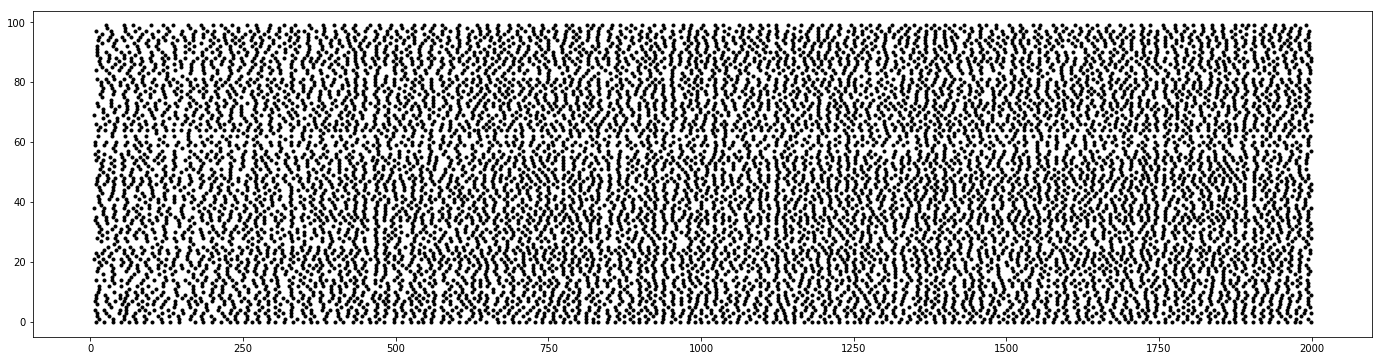

In [46]:
plt.figure( figsize = (24, 6) )
plt.plot( spike_monitor.t / b.ms, spike_monitor.i, 'k.' )
# plt.xlim( 1400, 1600 )

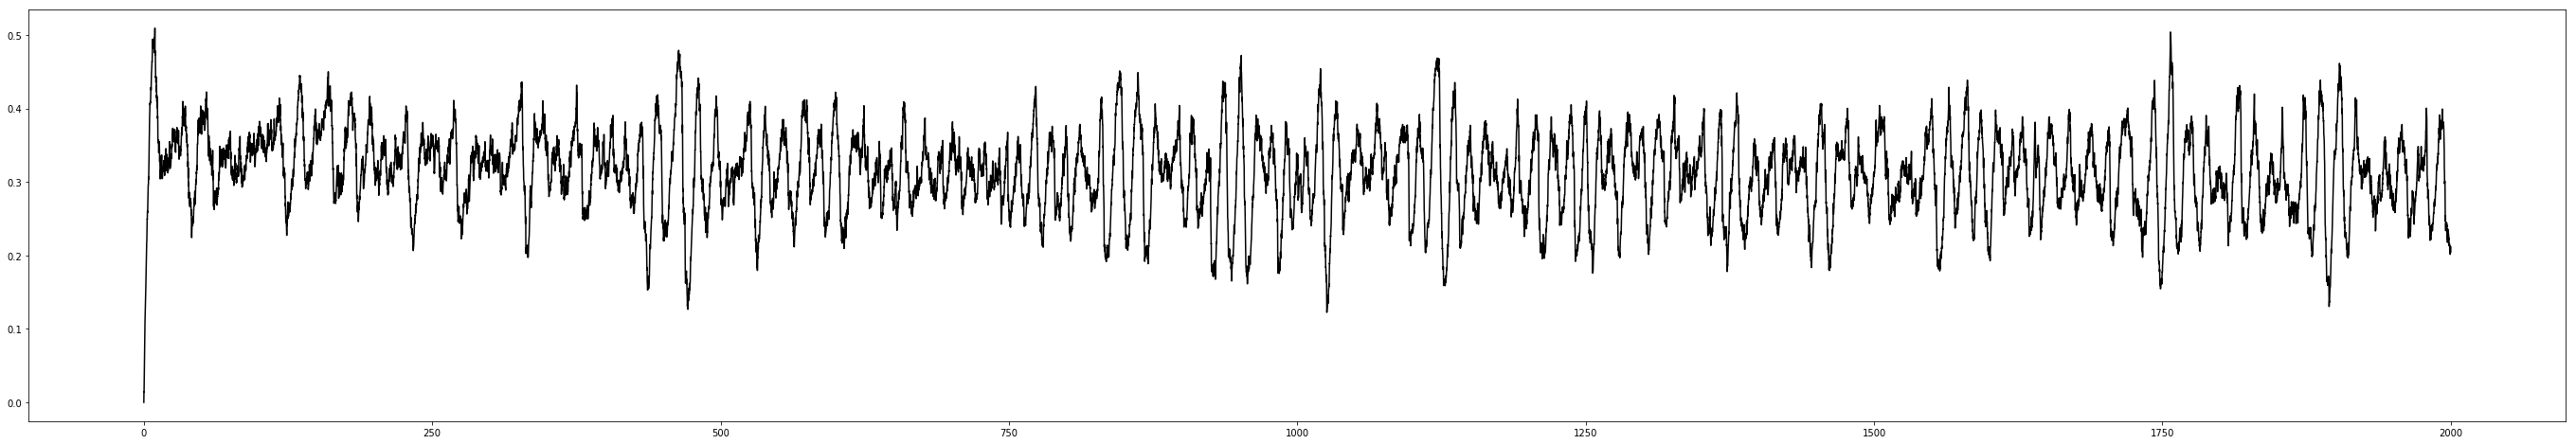

In [47]:
plt.figure( figsize = (48, 8) )
plt.plot( neuron_monitor.t / b.ms, np.mean( neuron_monitor.v, axis = 0 ), 'k-' )

In [48]:
import scipy.signal

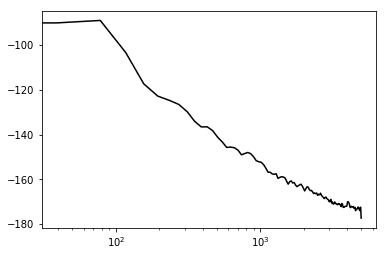

In [49]:
dt = (neuron_monitor.t[1] - neuron_monitor.t[0]) / b.second
f, Pxx = scipy.signal.welch( np.mean( neuron_monitor.v, axis = 0 )[neuron_monitor.t / b.ms > 300], fs = 1. / dt )
plt.semilogx( f, 20 * np.log10( Pxx ), 'k-' )

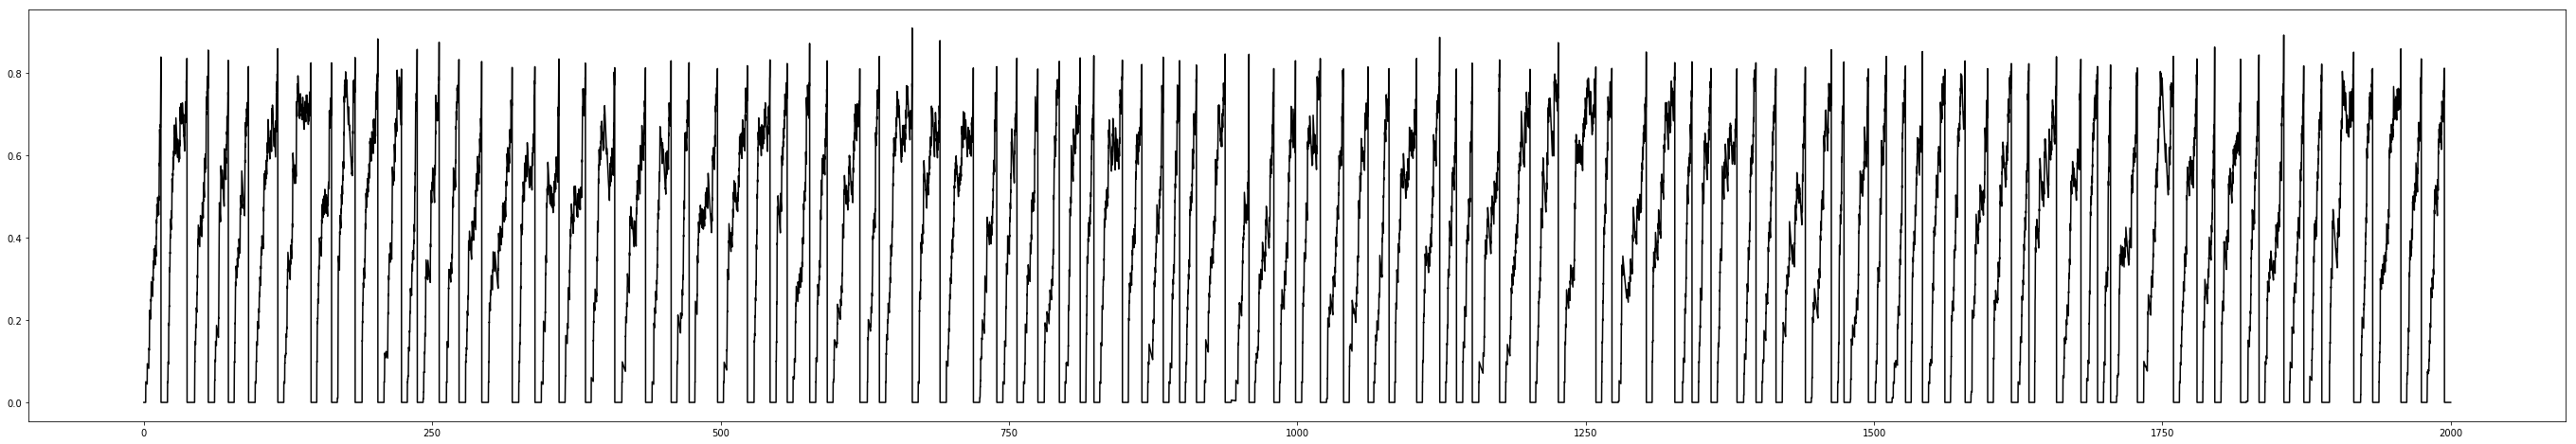

In [50]:
plt.figure( figsize = (48, 8) )
plt.plot( neuron_monitor.t / b.ms, neuron_monitor.v[1, :], 'k-' )

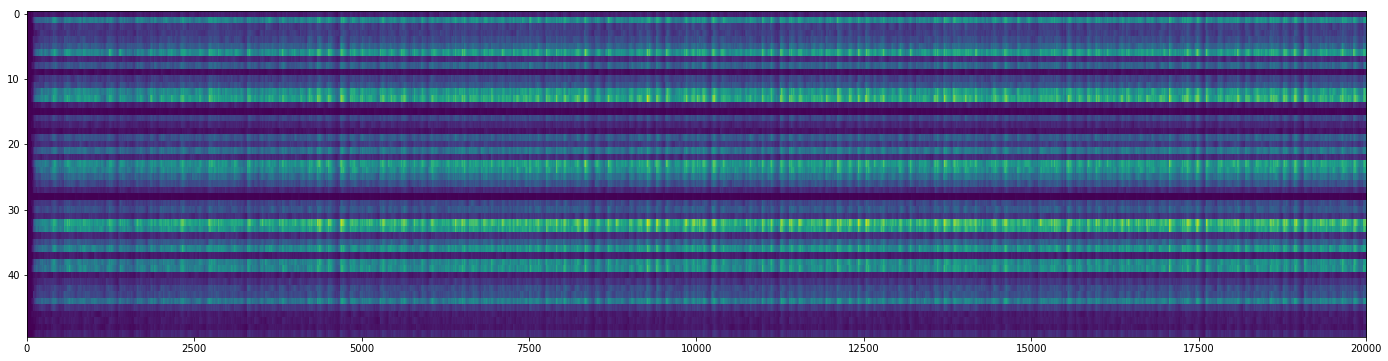

In [51]:
plt.figure( figsize = (24, 6) )
plt.imshow( astrocyte_monitor.a, aspect = 'auto' )

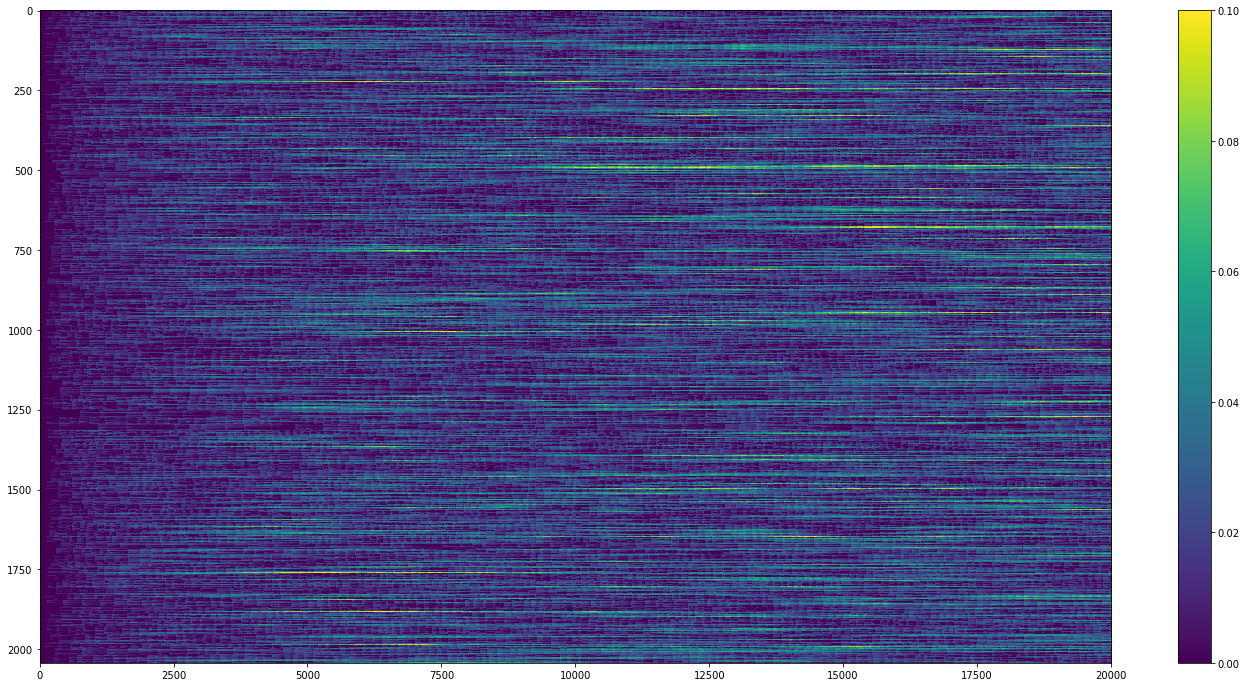

In [52]:
plt.figure( figsize = (24, 12) )
plt.imshow( weight_monitor.w, aspect = 'auto' )
plt.colorbar()

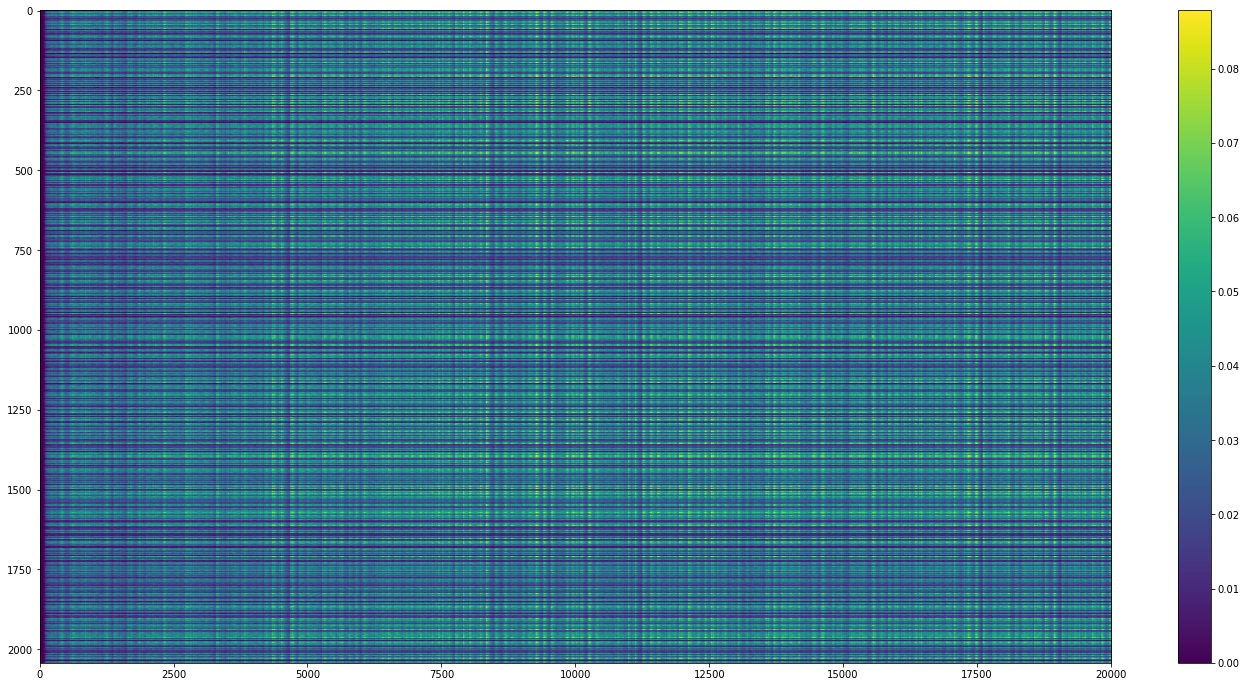

In [53]:
plt.figure( figsize = (24, 12) )
plt.imshow( weight_monitor.atot, aspect = 'auto' )
plt.colorbar()

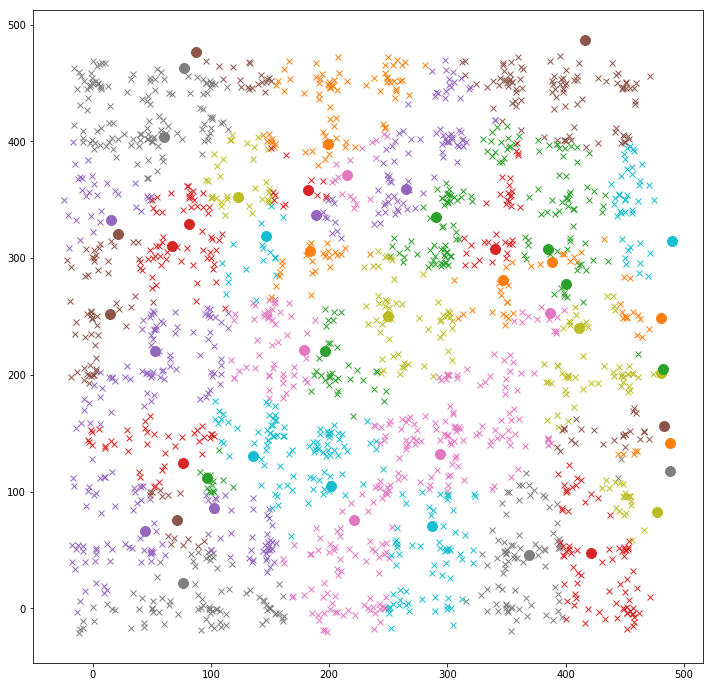

In [54]:
plt.figure( figsize = (12, 12) )
for i_ast in range( Na ):
    cur_synapses = synapses.i_ast == i_ast
    for i_synapse in range( synapses.i_ast.shape[0] ):
        if cur_synapses[i_synapse]:
            plt.plot( synapses.x_syn[i_synapse] / b.um, synapses.y_syn[i_synapse] / b.um, 'C{0}x'.format( i_ast % 9 + 1 ) )
    plt.plot( astrocytes.x[i_ast] / b.um, astrocytes.y[i_ast] / b.um, 'C{0}.'.format( i_ast % 9 + 1 ), markersize = 20 )

In [2]:
import gc
gc.collect()

11

In [27]:
synapse_input_betas = np.linspace( 0., 0.025, 100 )
result_Pxx = None

for i_beta, synapse_input_beta in enumerate( synapse_input_betas ):
    print( 'Run {0}, beta = {1}'.format( i_beta + 1, synapse_input_beta ) )
    
    b.restore()

    print( '    Running simulation...', end = '' )
    b.run( 2000 * b.ms )
    print( 'Done' )
    
    dt = (neuron_monitor.t[1] - neuron_monitor.t[0]) / b.second
    f, Pxx = scipy.signal.welch( np.mean( neuron_monitor.v, axis = 0 )[neuron_monitor.t / b.ms > 300], fs = 1. / dt )
    
    if result_Pxx is None:
        result_Pxx = np.zeros( (synapse_input_betas.shape[0], Pxx.shape[0]) )
    result_Pxx[i_beta, :] = Pxx

Run 1, beta = 0.0
    Running simulation...Done
Run 2, beta = 0.0002525252525252525
    Running simulation...Done
Run 3, beta = 0.000505050505050505
    Running simulation...Done
Run 4, beta = 0.0007575757575757576
    Running simulation...Done
Run 5, beta = 0.00101010101010101
    Running simulation...Done
Run 6, beta = 0.0012626262626262625
    Running simulation...Done
Run 7, beta = 0.0015151515151515152
    Running simulation...Done
Run 8, beta = 0.0017676767676767678
    Running simulation...Done
Run 9, beta = 0.00202020202020202
    Running simulation...Done
Run 10, beta = 0.0022727272727272726
    Running simulation...Done
Run 11, beta = 0.002525252525252525
    Running simulation...Done
Run 12, beta = 0.002777777777777778
    Running simulation...Done
Run 13, beta = 0.0030303030303030303
    Running simulation...Done
Run 14, beta = 0.0032828282828282827
    Running simulation...Done
Run 15, beta = 0.0035353535353535356
    Running simulation...Done
Run 16, beta = 0.003787878787

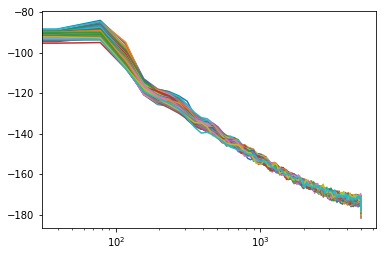

In [28]:
plt.semilogx( f, 20 * np.log10( result_Pxx ).T )
plt.show()

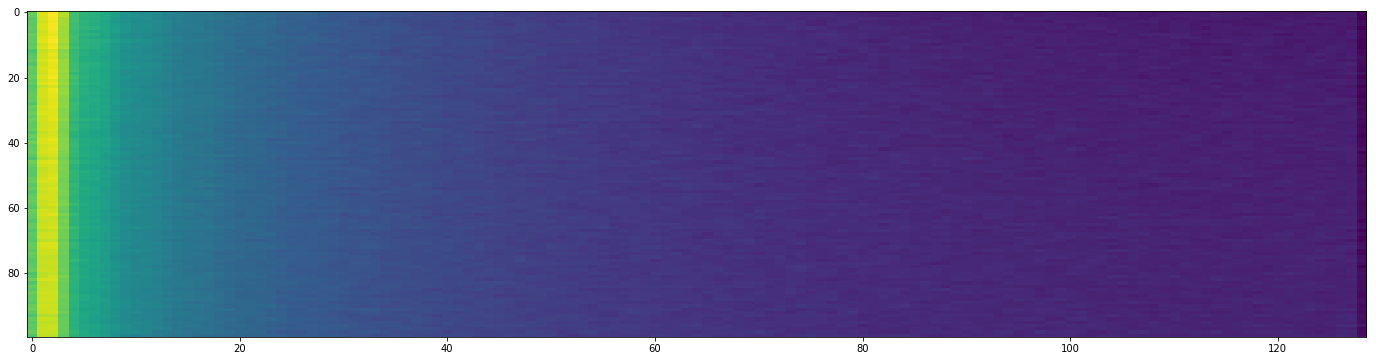

In [29]:
plt.figure( figsize = (24, 6) )
plt.imshow( np.log10( result_Pxx ), aspect = 'auto' )

In [30]:
result_Pxx_rel = np.zeros( result_Pxx.shape )
for i in range( result_Pxx.shape[0] ):
    result_Pxx_rel[i, :] = 20 * np.log10( result_Pxx[i, :] / result_Pxx[0, :] )

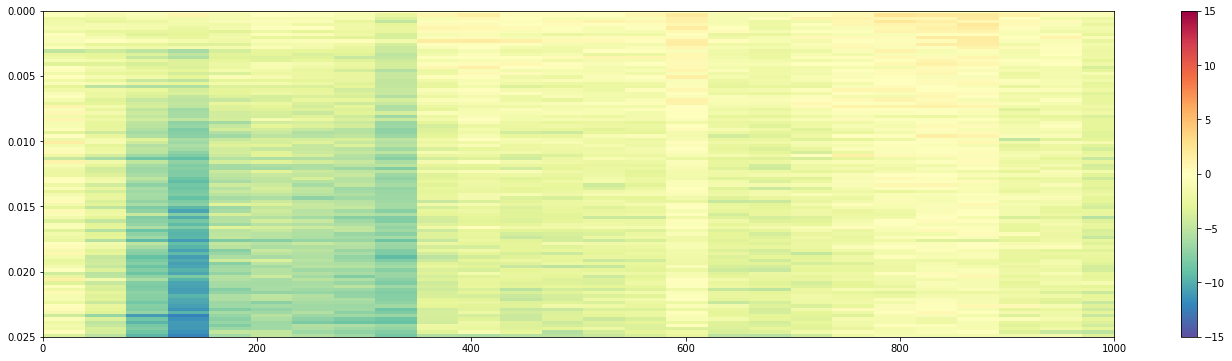

In [31]:
plt.figure( figsize = (24, 6) )
plt.imshow( result_Pxx_rel, aspect = 'auto', cmap = 'Spectral_r',
            extent = [f[0], f[-1], synapse_input_betas[-1], synapse_input_betas[0]] )
plt.clim( -15, 15 )
plt.xlim( 0, 1000 )
plt.colorbar()

## Astrocytes with multiple regions

In [15]:
b.start_scope()

Nx = 10
Ny = 10

N = Nx * Ny
Na = N // 2

regions = ['region_1', 'region_2']
n_regions = len( regions )

print( 'Setting up input...', end = '' )
N_input = 1000
input_freq = 40 * b.Hz
inputs = b.PoissonGroup( n_regions * N_input, input_freq )
inputs_region = { region: inputs[(i_region * N_input):((i_region+1) * N_input)]
                  for i_region, region in enumerate( regions ) }
print( 'Done' )

print( 'Setting up neurons...', end = '' )

tau_membrane = 10 * b.ms # 10
neuron_spacing = 50 * b.um
total_width = neuron_spacing * Nx
total_height = neuron_spacing * Ny
equations = '''
dv/dt = (I - v) / tau_membrane : 1 (unless refractory)
I : 1
x : meter
y : meter
i_region : integer
'''
neurons = b.NeuronGroup( n_regions * N, equations,
                         threshold = 'v > 0.8',
                         reset = 'v = 0',
                         refractory = 5 * b.ms,
                         method = 'rk4' )
# neurons.I = np.random.exponential( size = (N,) ) * 2.
neurons.I = 0
neurons_region = { region: neurons[(i_region * N):((i_region+1) * N)]
                   for i_region, region in enumerate( regions ) }
for i_region, region in enumerate( regions ):
    for i_x in range( Nx ):
        for i_y in range( Ny ):
            i_cur = i_x + (i_y * Ny)
            neurons_region[region].x[i_cur] = neuron_spacing * i_x
            neurons_region[region].y[i_cur] = neuron_spacing * i_y
            neurons_region[region].i_region = i_region

print( 'Done' )

print( 'Setting up input connectivity...' )
w_input = 0.05
p_input = 0.05
input_synapses_region = dict()
for region in regions:
    print( '    Region {0}'.format( region ) )
    input_synapses_region[region] = b.Synapses( inputs_region[region], neurons_region[region],
                                                on_pre = 'v_post += w_input' )
    input_synapses_region[region].connect( p = p_input )
print( 'Done' )

print( 'Setting up astrocytes...', end = '' )
        
tau_mean_field = 100 * b.ms
tau_astrocyte = 100 * b.ms
astrocyte_equations = '''
abar : 1
da/dt = ((abar - a) / tau_mean_field) - (a / tau_astrocyte) : 1
x : meter
y : meter
i_region : integer
'''
astrocytes = b.NeuronGroup( n_regions * Na, astrocyte_equations,
                            method = 'rk4' )
astrocytes_region = { region: astrocytes[(i_region * Na):((i_region+1) * Na)]
                      for i_region, region in enumerate( regions ) }
astrocytes.x = np.random.rand( n_regions * Na ) * total_width
astrocytes.y = np.random.rand( n_regions * Na ) * total_height
for i_region, region in enumerate( regions ):
    for i in range( Na ):
        astrocytes_region[region].i_region[i] = i_region

print( 'Done' )

print( 'Setting up astrocyte syncytium...', end = '' )
syncytium_equations = '''
abar_post = (1 / (n_regions * Na)) * a_pre (summed)
'''
syncytium = b.Synapses( astrocytes, astrocytes )
syncytium.connect()
print( 'Done' )

print( 'Setting up synapses...' )

synapse_connect_p = np.array( [[0.2, 0.05], [0.05, 0.2]] )
synapse_r_max = 25 * b.um
tau_astro_synapse = 100 * b.ms
tau_pre_synapse = 20 * b.ms
tau_post_synapse = 20 * b.ms
w_max = 0.1
Apre = -0.01
Apost = -Apre * ( tau_pre_synapse / tau_post_synapse ) * 0.95 # 1.05
synapse_equations = '''
atot : 1
dw/dt = (-atot * w) / tau_astro_synapse : 1
dapre/dt = -apre / tau_pre_synapse : 1 (event-driven)
dapost/dt = -apost / tau_post_synapse : 1 (event-driven)
x_syn : meter
y_syn : meter
i_ast : integer
i_region_syn : integer
'''
synapse_on_pre = '''
v_post += w
apre += Apre
w = clip( w + apost, 0, w_max)
'''
synapse_on_post = '''
apost += Apost
w = clip( w + apre, 0, w_max)
'''
synapses = b.Synapses( neurons, neurons, synapse_equations,
                       on_pre = synapse_on_pre,
                       on_post = synapse_on_post,
                       method = 'rk4' )

for i_region_loop, pre_region in enumerate( regions ):
    for j_region_loop, post_region in enumerate( regions ):
        print( '    Connecting {0} -> {1}'.format( pre_region, post_region ) )
#         synapses.connect( condition = '(i >= i_region_loop * N) and (i < (i_region_loop+1) * N) and (j >= j_region_loop * N) and (j < (j_region_loop+1) * N)',
#                           p = synapse_connect_p[i_region_loop, j_region_loop] )
        for i in range( i_region_loop * N, (i_region_loop+1) * N ):
            if i > 0 and i % 10 == 0:
                print( '        From neuron {0}'.format( i ) )
            for j in range( j_region_loop * N, (j_region_loop+1) * N ):
                if i == j:
                    continue
                synapses.connect( i = i, j = j, p = synapse_connect_p[i_region_loop, j_region_loop] )
synapses.w = w_max

astrocyte_pre_neurons = [ [] for i_ast in range( n_regions * Na ) ]
astrocyte_synapses = [ [] for i_ast in range( n_regions * Na ) ]
for i_synapse, pre_neuron in enumerate( synapses.i ):
    if i_synapse > 0 and i_synapse % 100 == 0:
        print( '    Prepping synapse {0}'.format( i_synapse ) )
    
    r_cur = synapse_r_max * np.random.rand()
    theta_cur = 2 * np.pi * np.random.rand()
    cur_x_syn = synapses.x_post[i_synapse] + r_cur * np.cos( theta_cur )
    cur_y_syn = synapses.y_post[i_synapse] + r_cur * np.sin( theta_cur )
    synapses.x_syn[i_synapse] = cur_x_syn
    synapses.y_syn[i_synapse] = cur_y_syn
    v_cur = np.array( [cur_x_syn, cur_y_syn] )
    
    cur_i_region_syn = synapses.i_region_post[i_synapse]
    synapses.i_region_syn[i_synapse] = cur_i_region_syn
    
    astrocyte_distances = np.zeros( (Na,) )
    for i_ast in range( Na ):
        v_ast = np.array( [astrocytes_region[regions[cur_i_region_syn]].x[i_ast],
                           astrocytes_region[regions[cur_i_region_syn]].y[i_ast]] )
        astrocyte_distances[i_ast] = np.linalg.norm( v_ast - v_cur )
    cur_i_ast_in_region = np.argmin( astrocyte_distances )
    cur_i_ast = (cur_i_region_syn * Na) + cur_i_ast_in_region
    synapses.i_ast[i_synapse] = cur_i_ast
    
    astrocyte_pre_neurons[cur_i_ast].append( pre_neuron )
    astrocyte_synapses[cur_i_ast].append( i_synapse )

print( 'Done' )

print( 'Setting up presynaptic neuron -> astrocycte connections...', end = '' )
    
astro_input_phi = 0.05
astro_input_equations = '''
phi = astro_input_phi : 1
'''
astro_input_on_pre = '''
a_post += phi
'''
astro_input = b.Synapses( neurons, astrocytes, astro_input_equations,
                          on_pre = astro_input_on_pre,
                          method = 'rk4' )
for i_ast, pre_neurons in enumerate( astrocyte_pre_neurons ):
    for pre_neuron in pre_neurons:
        astro_input.connect( i = pre_neuron, j = i_ast )

print( 'Done' )

print( 'Setting up astrocyte -> synapse connections...', end = '' )

synapse_input_beta = 0. # 0.02
synapse_input_equations = '''
beta = synapse_input_beta : 1
atot_post = beta * a_pre : 1 (summed)
'''
synapse_input = b.Synapses( astrocytes, synapses, synapse_input_equations,
                            method = 'rk4' )
for i_ast, ast_synapses in enumerate( astrocyte_synapses ):
    for ast_synapse in ast_synapses:
        synapse_input.connect( i = i_ast, j = ast_synapse )

print( 'Done' )

neuron_monitor = b.StateMonitor( neurons, 'v', record = True )
astrocyte_monitor = b.StateMonitor( astrocytes, 'a', record = True )
weight_monitor = b.StateMonitor( synapses, ['w', 'atot'], record = True )
spike_monitor = b.SpikeMonitor( neurons )

b.store()

Setting up input...Done
Setting up neurons...Done
Setting up input connectivity...
    Region region_1
    Region region_2
Done
Setting up astrocytes...Done
Setting up astrocyte syncytium...Done
Setting up synapses...
    Connecting region_1 -> region_1
        From neuron 10
        From neuron 20
        From neuron 30
        From neuron 40
        From neuron 50
        From neuron 60
        From neuron 70
        From neuron 80
        From neuron 90
    Connecting region_1 -> region_2
        From neuron 10
        From neuron 20
        From neuron 30
        From neuron 40
        From neuron 50
        From neuron 60
        From neuron 70
        From neuron 80
        From neuron 90
    Connecting region_2 -> region_1
        From neuron 100
        From neuron 110
        From neuron 120
        From neuron 130
        From neuron 140
        From neuron 150
        From neuron 160
        From neuron 170
        From neuron 180
        From neuron 190
    Connecting regio

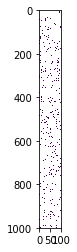

In [29]:
W = np.full( (len( inputs_region['region_1'] ), len( neurons_region['region_1'] )), np.nan )
W[input_synapses_region['region_1'].i[:], input_synapses_region['region_1'].j[:]] = 1. #input_synapses_region['region_1'].w[:]
plt.imshow( W )

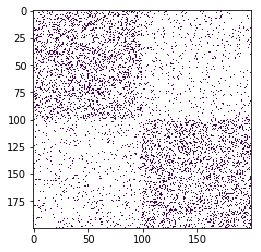

In [16]:
W = np.full( (len( neurons ), len( neurons )), np.nan )
W[synapses.i[:], synapses.j[:]] = synapses.w[:]
plt.imshow( W )

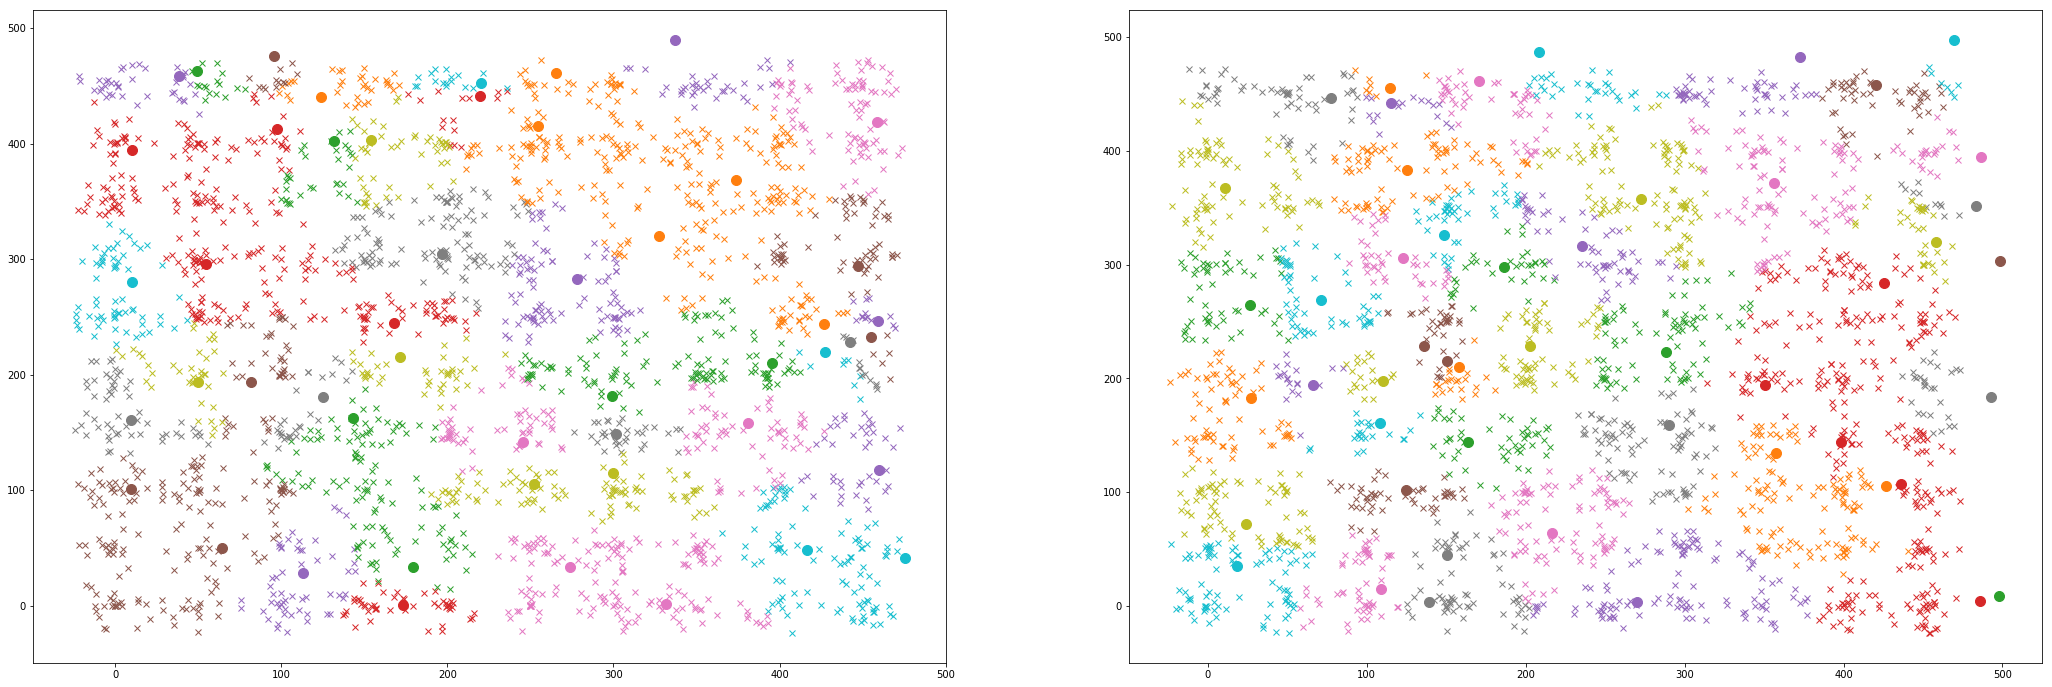

In [17]:
fig, axs = plt.subplots( 1, n_regions, figsize = (36, 12) )

for i_region, region in enumerate( regions ):
    for i_ast_in_region in range( Na ):
        i_ast = (i_region * Na) + i_ast_in_region
        cur_synapses = synapses.i_ast == i_ast
        for i_synapse in range( synapses.i_ast.shape[0] ):
            if cur_synapses[i_synapse]:
                axs[i_region].plot( synapses.x_syn[i_synapse] / b.um, synapses.y_syn[i_synapse] / b.um, 'C{0}x'.format( i_ast % 9 + 1 ) )
        axs[i_region].plot( astrocytes.x[i_ast] / b.um, astrocytes.y[i_ast] / b.um, 'C{0}.'.format( i_ast % 9 + 1 ), markersize = 20 )

In [18]:
b.restore()

synapse_input_beta = 0.02

print( 'Running simulation...', end = '' )
b.run( 2000 * b.ms )
print( 'Done' )

Running simulation...Done


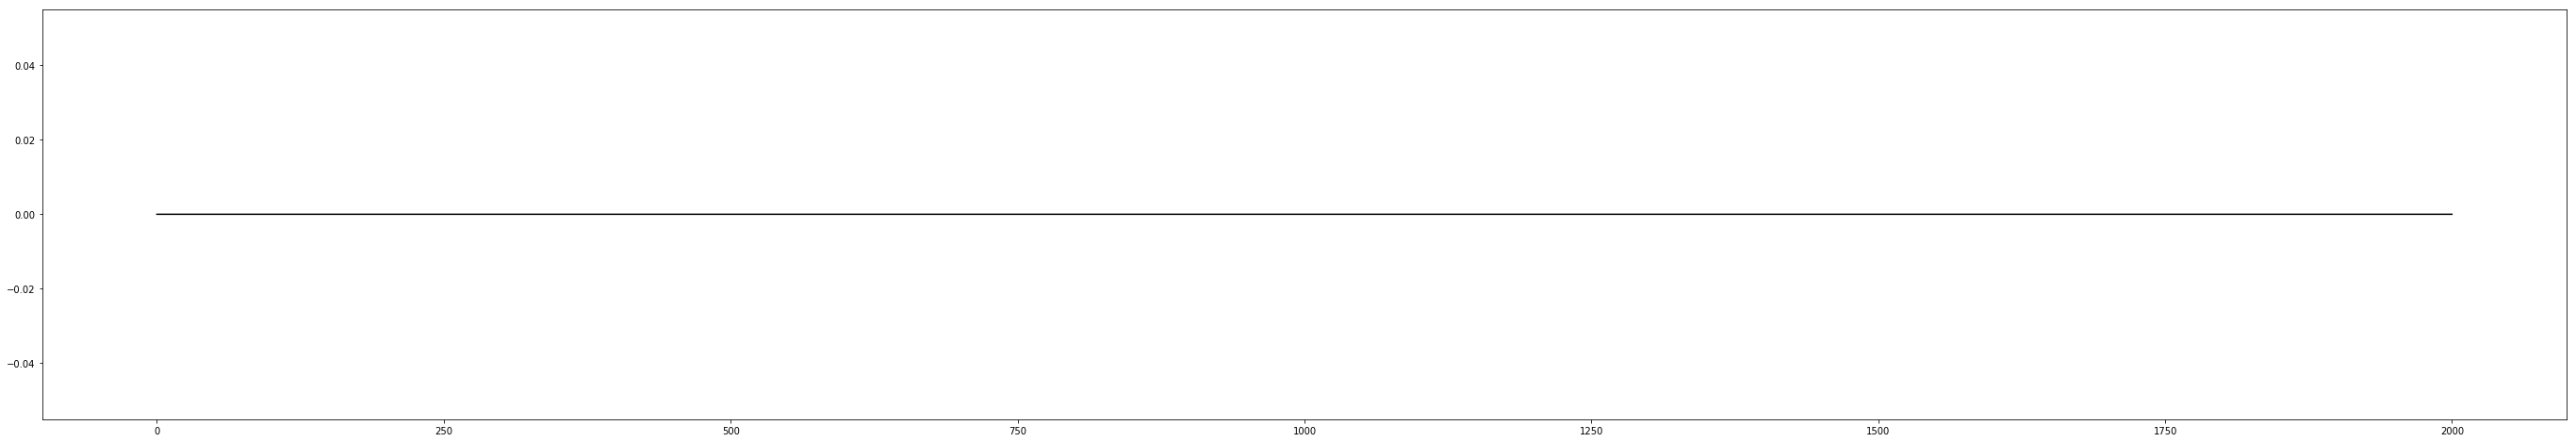

In [22]:
plt.figure( figsize = (48, 8) )
plt.plot( neuron_monitor.t / b.ms, neuron_monitor.v[2, :], 'k-' )

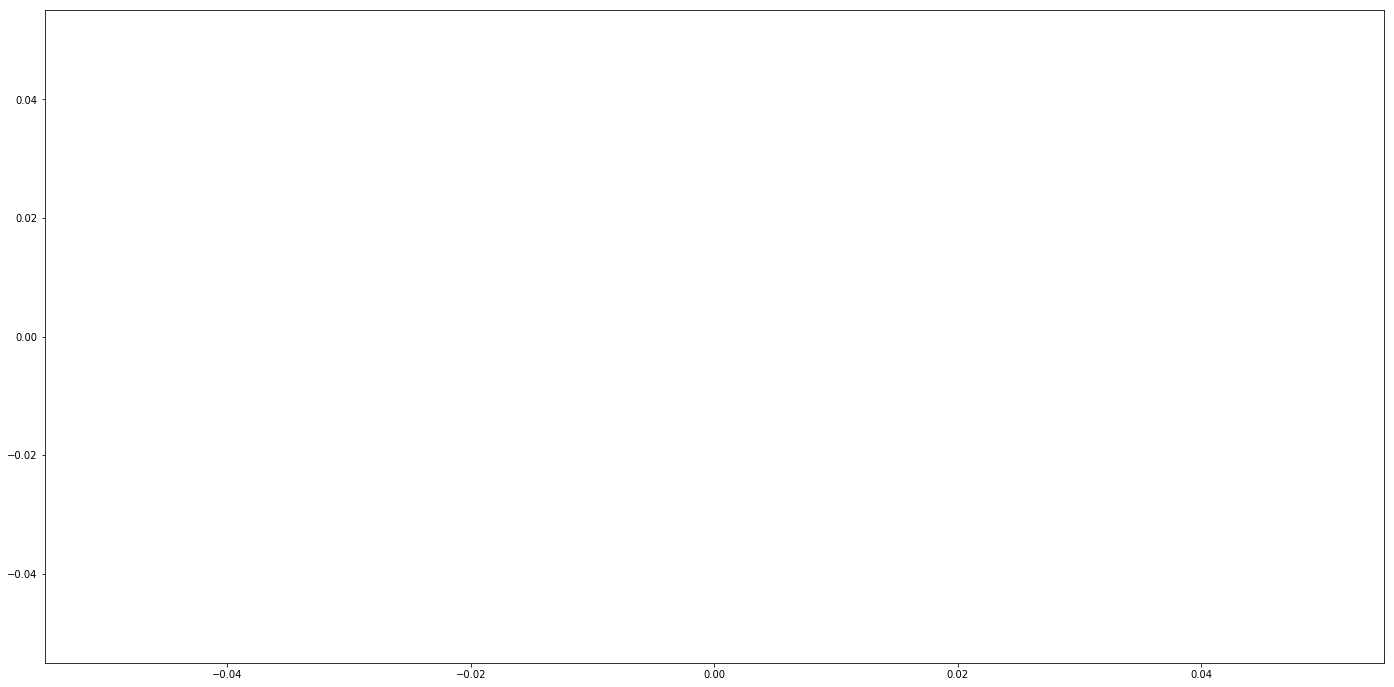

In [19]:
plt.figure( figsize = (24, 12) )
plt.plot( spike_monitor.t / b.ms, spike_monitor.i, 'k.' )
# plt.xlim( 1400, 1600 )